# Imports #

In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
import time

import gym
import math
import random
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
random.seed(100)
env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
plt.ion()

device = torch.device("cuda")

In [79]:
class VPGNetwork(nn.Module):
    def __init__(self, observation_dim, action_dim, hidden_dims=[32], discrete_action=True):
        super(VPGNetwork, self).__init__()
        self.discrete_action = discrete_action
        self.layers = [nn.Linear(observation_dim, hidden_dims[0])]
        self.add_module(f"layer{1}", self.layers[0])
        for i in range(0, len(hidden_dims)-1):
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            self.add_module(f"layer{len(self.layers)}", self.layers[-1])
        self.layers.append(nn.Linear(hidden_dims[-1], action_dim))
        self.add_module(f"layer{len(self.layers)}", self.layers[-1])
    
    def _action_calculation(self, observation):
        if self.discrete_action:
            return F.softmax(observation, dim=0)
        else:
            return observation
    
    def forward(self, observation):
        for layer in self.layers:
            observation = F.relu(layer(observation))
        return self._action_calculation(observation)

In [80]:
BATCH_SIZE = 5000
OBSERVATION_DIM = env.observation_space.shape[0]
ACTION_DIM = env.action_space.n

policy = VPGNetwork(OBSERVATION_DIM, ACTION_DIM, [32, 32], True)

optimizer = optim.RMSprop(policy.parameters(), lr=0.005)

In [66]:
list(policy.modules())

[VPGNetwork(
   (layer1): Linear(in_features=4, out_features=32, bias=True)
   (layer2): Linear(in_features=32, out_features=32, bias=True)
   (layer3): Linear(in_features=32, out_features=2, bias=True)
 ),
 Linear(in_features=4, out_features=32, bias=True),
 Linear(in_features=32, out_features=32, bias=True),
 Linear(in_features=32, out_features=2, bias=True)]

In [68]:
def choose_action(obs):
    act_probs = policy(torch.as_tensor(obs).float())
    act_dist = torch.distributions.Multinomial(1, probs=act_probs)
    sample = act_dist.sample()
    return sample.max(0)[1].item(), act_probs

In [14]:
def act(n_episodes):
    for _ in range(0, n_episodes):
        obs = env.reset()
        done = False
        while not done:
            env.render()
            action, _ = choose_action(obs)
            obs, _, done, _ = env.step(action)
        time.sleep(0.01)
    env.close()

In [85]:
def do_one_epoch():
    trajectories_rewards = []
    trajectories_acts = []
    trajectories_act_probs = []
    trajectories_obs = []
    while True:
        # rendering = i == 1
        obs = env.reset()
        done = False
        episode_len = 0
        while not done:
            action, act_probs = choose_action(obs)
            trajectories_act_probs.append(act_probs)
            trajectories_acts.append([action])
            trajectories_obs.append(obs)
            episode_len += 1
            obs, _, done, _ = env.step(action)
        trajectories_rewards += reversed(range(0, episode_len))
        
        if len(trajectories_obs) > BATCH_SIZE:
            break

    rews = torch.as_tensor(trajectories_rewards).float()
    act_probs = torch.stack(trajectories_act_probs).float()
    acts = torch.as_tensor(trajectories_acts).long()
    obs = torch.as_tensor(trajectories_obs).float()

    log_probs = (torch.zeros(act_probs.shape).scatter_(1, acts, 1) * torch.log(act_probs)).sum(dim=1)
    loss = -torch.mean(log_probs * rews)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    plot_grad_flow(policy.named_parameters())

    avg_reward = torch.mean(rews)
    return avg_reward

In [42]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend(
        [
            mplt.lines.Line2D([0], [0], color="c", lw=4),
            mplt.lines.Line2D([0], [0], color="b", lw=4),
            mplt.lines.Line2D([0], [0], color="k", lw=4)
        ],
        ['max-gradient', 'mean-gradient', 'zero-gradient']
    )
    plt.show()

In [86]:
def train(epochs):
    epoch_avg_rewards = []
    for i in range(0, epochs):
        avg_rew = do_one_epoch()
        epoch_avg_rewards.append(avg_rew)
        print(f"epoch{i} done, avg_reward: {avg_rew}")
    plt.plot(epoch_avg_rewards)

In [84]:
act(4)

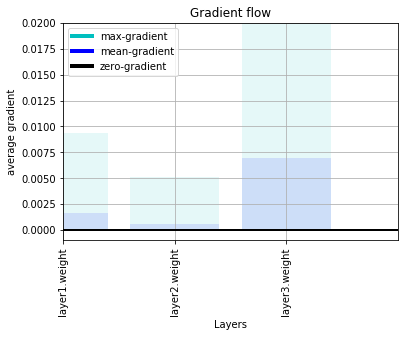

epoch0 done, avg_reward: 4.359169006347656


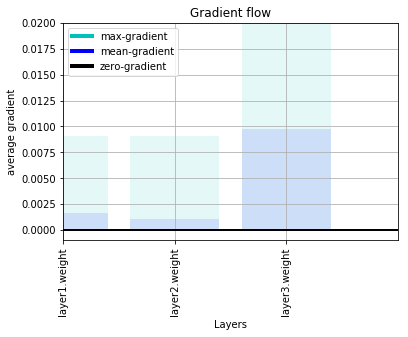

epoch1 done, avg_reward: 4.361149787902832


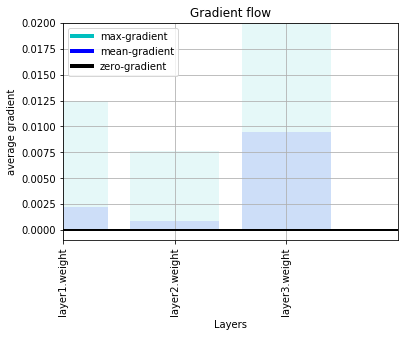

epoch2 done, avg_reward: 4.425408840179443


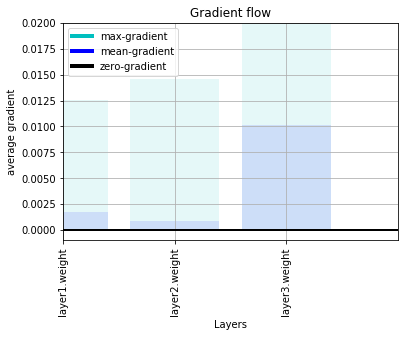

epoch3 done, avg_reward: 4.485628604888916


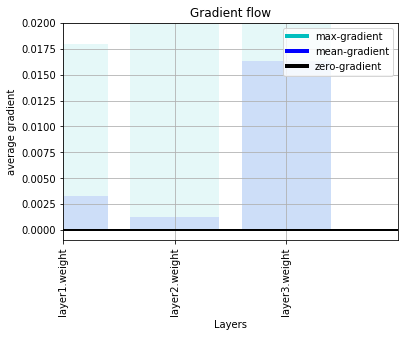

epoch4 done, avg_reward: 4.557730674743652


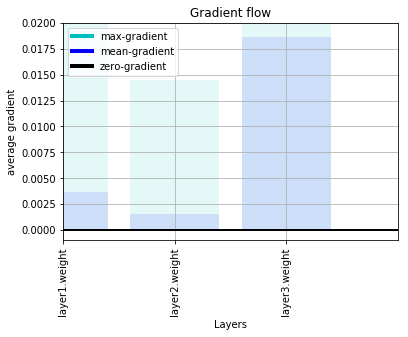

epoch5 done, avg_reward: 4.750298976898193


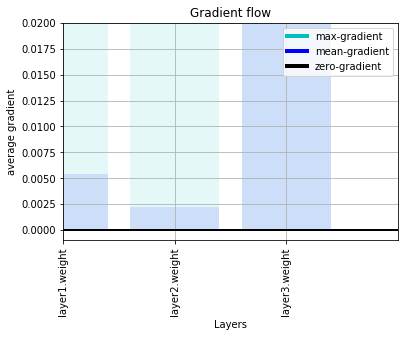

epoch6 done, avg_reward: 5.141230583190918


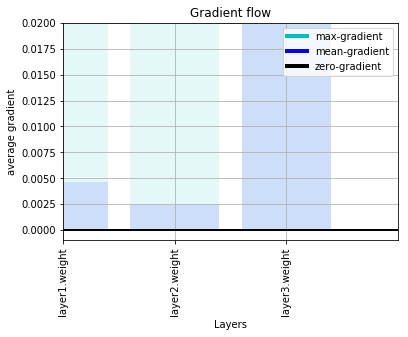

epoch7 done, avg_reward: 5.702837944030762


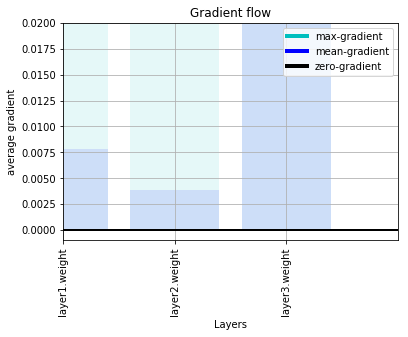

epoch8 done, avg_reward: 6.986011028289795


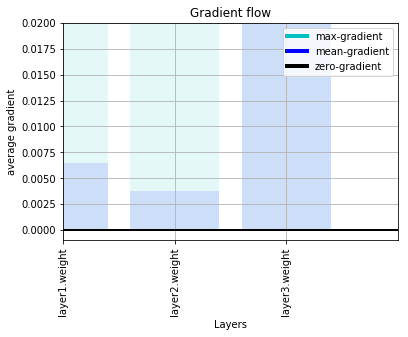

epoch9 done, avg_reward: 9.186488151550293


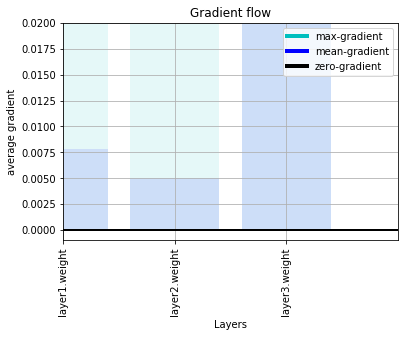

epoch10 done, avg_reward: 12.017186164855957


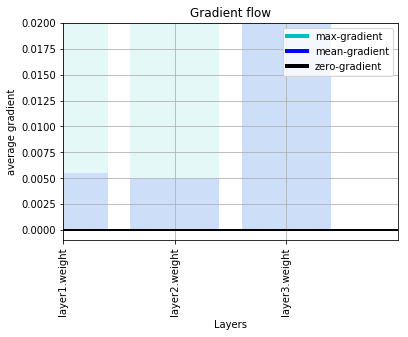

epoch11 done, avg_reward: 12.22335147857666


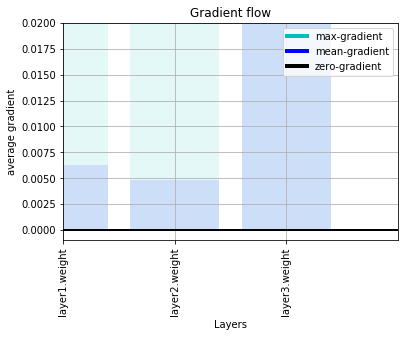

epoch12 done, avg_reward: 16.22901725769043


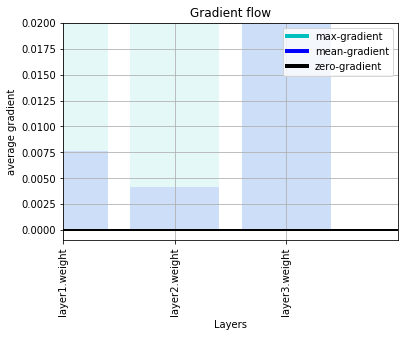

epoch13 done, avg_reward: 19.944421768188477


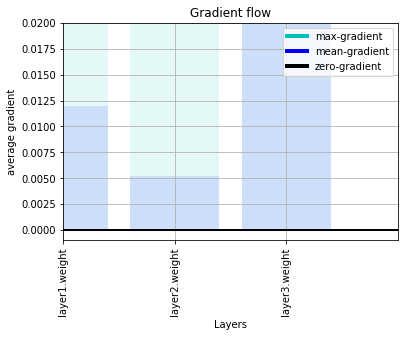

epoch14 done, avg_reward: 25.502197265625


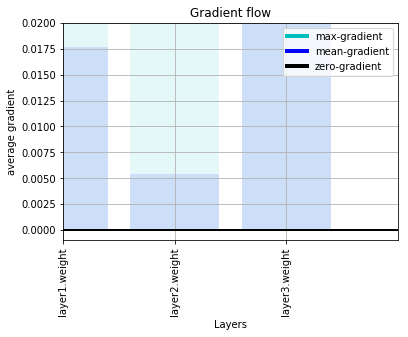

epoch15 done, avg_reward: 31.56358528137207


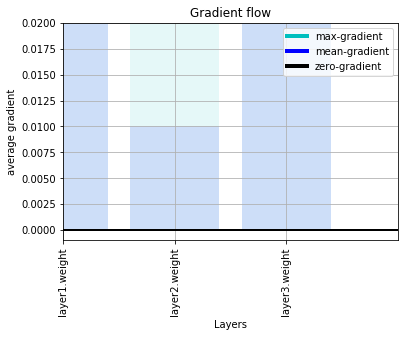

epoch16 done, avg_reward: 31.775287628173828


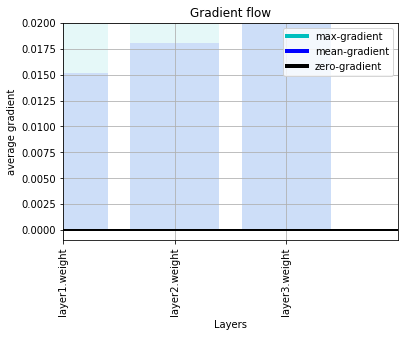

epoch17 done, avg_reward: 23.246673583984375


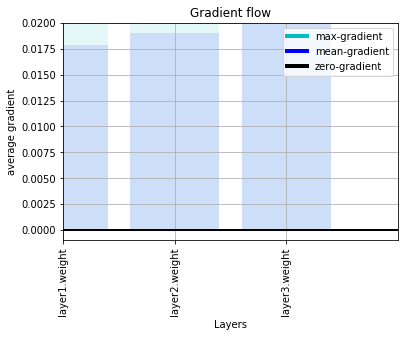

epoch18 done, avg_reward: 18.714313507080078


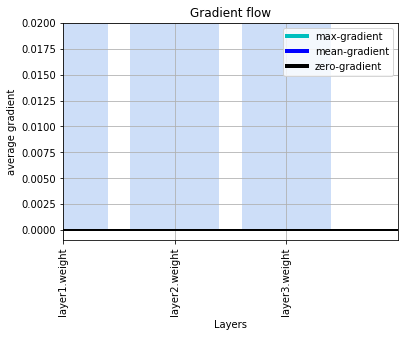

epoch19 done, avg_reward: 47.20398712158203


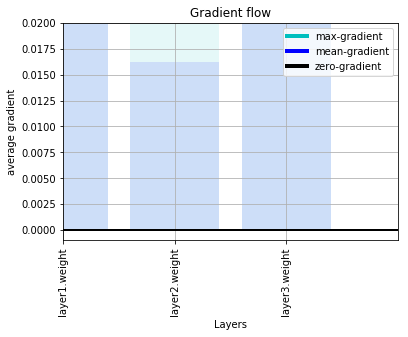

epoch20 done, avg_reward: 17.234424591064453


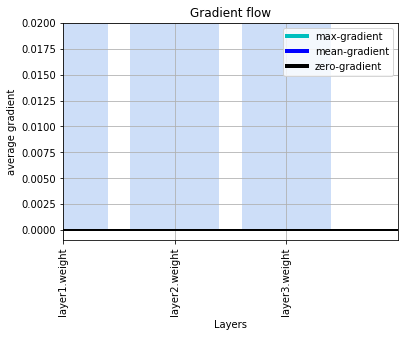

epoch21 done, avg_reward: 52.65056610107422


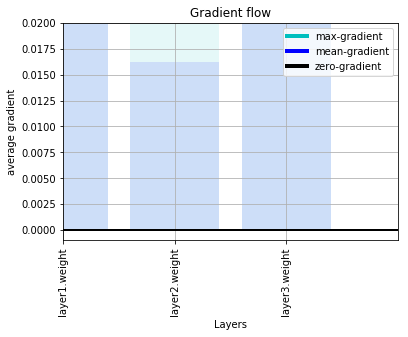

epoch22 done, avg_reward: 71.99044799804688


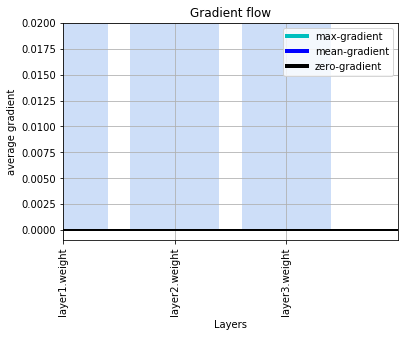

epoch23 done, avg_reward: 147.6336669921875


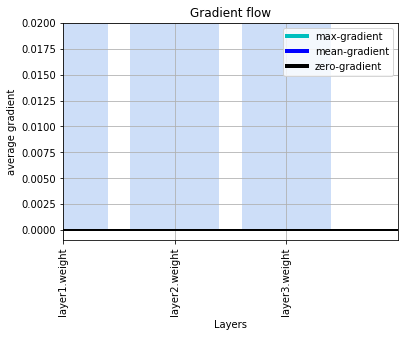

epoch24 done, avg_reward: 32.04772186279297


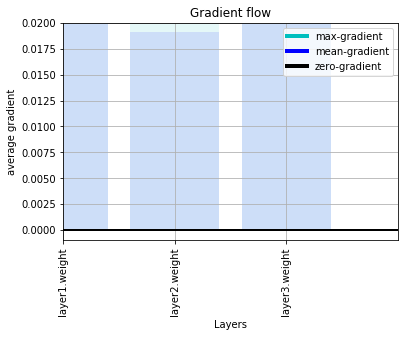

epoch25 done, avg_reward: 121.93968963623047


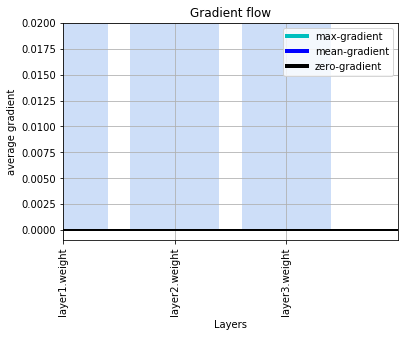

epoch26 done, avg_reward: 291.61187744140625


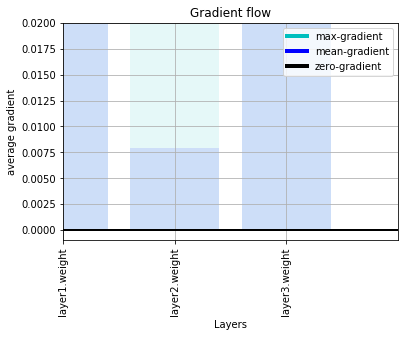

epoch27 done, avg_reward: 74.12908172607422


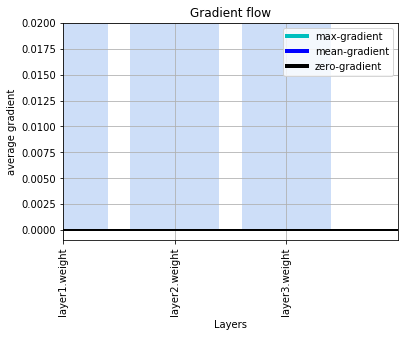

epoch28 done, avg_reward: 125.34345245361328


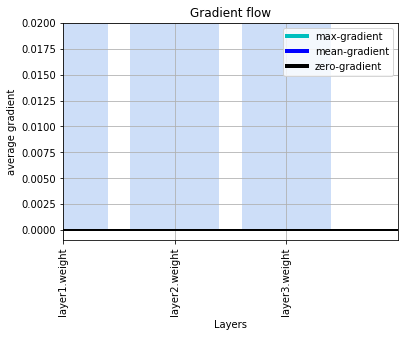

epoch29 done, avg_reward: 530.1207885742188


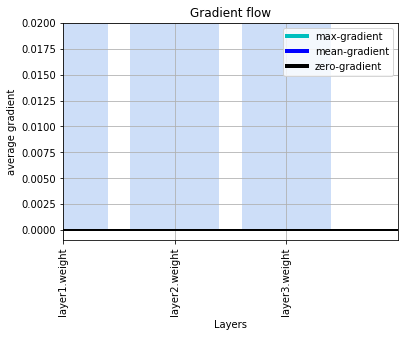

epoch30 done, avg_reward: 150.0998077392578


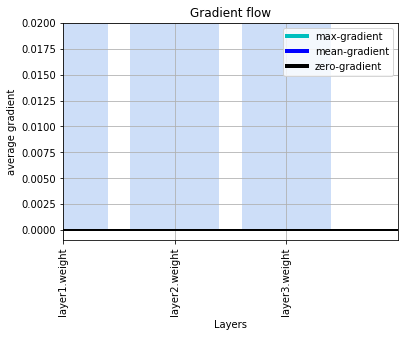

epoch31 done, avg_reward: 179.23094177246094


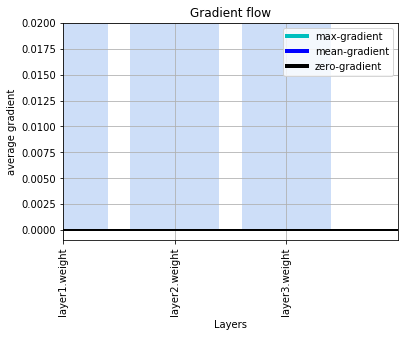

epoch32 done, avg_reward: 406.29437255859375


KeyboardInterrupt: 

In [83]:
train(50)